# Predicting bat speed from biomechanical data

# Why Bat Speed Matters

A hitter's approach in any given at bat involves a hit-hit ball in play. Whether it's behind a runner or a deep fly ball, nobody would object to the idea that, excluding bunts, hitting a baseball hard is a good outcome. Yet, a league-average hitter manages to succeed only 2 to 3 times out of 10 plate appearances. With so many uncontrollable variables, the hitter must maximize what can be controlled. In a [bat-ball collision](http://baseball.physics.illinois.edu/AJP-Feb2003.pdf), there are three primary factors affecting the post-collision velocity of a struck ball, or exit velocity: the initial ball/bat velocities and collision efficiency, also known as Driveline Baseball's metric called [Smash Factor](https://www.drivelinebaseball.com/2021/02/smash-factor-a-data-driven-approach-to-assessing-the-hit-tool/). The latter depends on where the ball is impacted in relation to the "sweet spot," the area on the bat experiencing the least vibration. Barreling a baseball is hard enough, though a hitter's swing speed and approach are fully within their control. Therefore, in a vacuum, if two hitters hit the same pitch at the same spot on the barrel, then the player who is able to move the bat the fastest at impact will produce a higher exit velocity. 

## Exit Velocity vs. Bat Speed

Physics aside, [statistical evidence](https://www.drivelinebaseball.com/2019/05/debunking-bat-speed-myths/) points to a significant positive linear relationship between bat speed and exit velocity, and higher average bat speeds per hitter also correlate with lower average time to contact and a lower rate of mishits, supporting the notion that increasing bat speed raises the floor for productive mishits. From a player evaluation standpoint, Major League Baseball scouts consider [bat speed an aspect of the nebulous "hit tool"](https://blogs.fangraphs.com/scouting-the-hit-tool-pt-1/) and a prerequisite for playing in The Show. Essentially, bat speed is to hitters as velocity is to pitchers – swinging the bat faster generally produces more positive outcomes. 

In [435]:
poi.exit_velo_mph_x.corr(poi.bat_speed_mph_contact_x)

0.7077582461438117

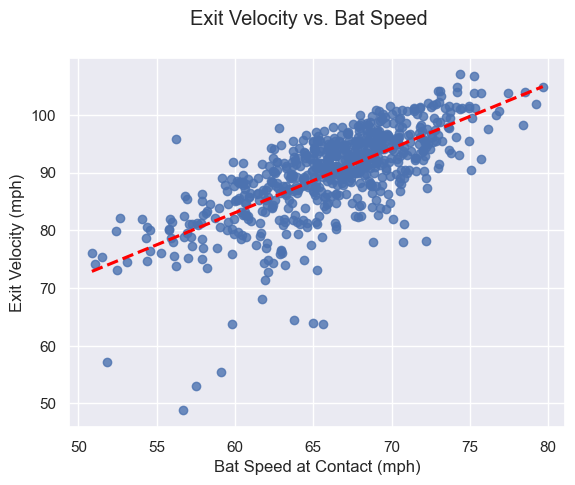

In [436]:
# Plot exit velocity versus bat speed
sb.regplot(y=poi.exit_velo_mph_x, x=poi.bat_speed_mph_contact_x, ci=None, line_kws={'color':'red', 'linestyle':'dashed'})
plt.xlabel("Bat Speed at Contact (mph)")
plt.ylabel("Exit Velocity (mph)")
plt.suptitle("Exit Velocity vs. Bat Speed")
plt.show()

# How to Increase Bat Speed

There have been [multiple studies revealing significant increases in bat speed](https://journals.lww.com/nsca-jscr/fulltext/2009/07000/Contributing_Factors_for_Increased_Bat_Swing.42.aspx?s=09) from various training methods. Progressive, velocity-based resistance training enhances raw strength, power, and lean body mass, thereby increasing the total amount of force applied into the ground. Generating this ground force, however, is only a piece of the puzzle. Although many players meet the requisite strength benchmark, the ability to *quickly* and *efficiently* transfer this energy into the swing is what separates elite hitters from the rest. Hitting, after all, is a sequential and rotational movement, and proper sequencing and movement patterns efficiently transfer energy through the kinetic chain. Specific resistance implements, such as medicine balls and overweighted/underweighted bats, train fast-twitch muscle groups and explosiveness while reinforcing movement efficiency. Although a rarity among hitting programs, these evidence-based methods produce greater force outputs and establish better rotational movement patterns, unlocking an athlete's untapped bat speed. 

# Movement is King

As mentioned earlier, elite hitters are elite movers. Not every ballplayer who can deadlift 400 pounds can hit a 95 mile-per-hour heater 400 feet; nor are all power hitters physical specimens built like Aaron Judge or Matt Olson. Otherwise, how would players like Mookie Betts or Jose Altuve put up multiple 30-plus home-run seasons? 

# The OpenBiomechanics Project

Motion capture (sometimes referred as "mocap") technology is permeating throughout all levels of baseball in an attempt to gather and study kinematic movement data, offering insight into the biomechaical features of elite-level movers. Driveline Baseball's [OpenBiomechanics Project](https://www.openbiomechanics.org) (OBP) is the "largest high-fidelity, open-source set of raw and processed motion capture files on elite baseball players in the world." Utilizing this information, this project aims to identify the most important biomechanical features contributing to bat speed. 

# Exploratory Data Analysis

The OBP hitting database consists of biomechanical point-of-interest metrics (`poi_metrics.csv`), pitch-level HitTrax data (`hittrax.csv`), and athlete metadata (`metadata.csv`) for 98 hitters. 

In [437]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [438]:
# Load datasets
poi = pd.read_csv('poi_metrics.csv')
metadata = pd.read_csv('metadata.csv')
#hittrax = pd.read_csv('hittrax.csv')

metadata.user.nunique() # number of athletes
poi.session.nunique() # number of sessions

98

In [439]:
# Select relevant columns from metadata
metadata = metadata[["session_swing", "session_mass_lbs", "session_height_in", "athlete_age"]]

# Join with POI DataFrame
df = poi.set_index("session_swing").join(metadata.set_index("session_swing"))

df.shape

(677, 129)

The `poi` dataset contains swing metrics measured by motion capture technology and kinematic metrics for different body parts at the various phases of the swing. The `metadata` CSV contains relevant biological information about each athlete, such as age, height, and weight, that may be associated with bat speed. The thought is that older, taller, and/or heavier athletes may tend to swing the bat faster than less developed or undersized athletes. The final `df` consists of 677 total entries and 129 columns. 

## Dependent Variable 

The dependent variable to be modeled is bat speed at contact measured in miles per hour (mph). While `blast_bat_speed_mph_x` measures bat speed using a sensor placed on the knob of the bat, `bat_speed_mph_contact_x` is measured using motion capture cameras that provide more accurate and reliable readings. It also has no missing data points and less variation, while the Blast data is missing 30 out of 677 entries and some clear outliers. The average swing speed is 66.2 mph with a standard deviation of 4.8 mph. The slowest recorded bat speed is 50.9 mph while the fastest is a whopping 79.6 mph, which is considered elite at the professional level. There appear to be multiple outliers on both sides indicated by the box plot below. 

In [440]:
# Motion capture bat speed at contact summary statistics
bs_sum_stats = df.bat_speed_mph_contact_x.describe().round(2)

# Number of missing entries
bs_missing = df.bat_speed_mph_contact_x.isnull().sum()

# Add missing entry percentage to summary statistics output
bs_sum_stats.loc["missing"] = bs_missing

bs_sum_stats

count      677.00
mean        66.20
std          4.79
min         50.86
25%         63.28
50%         66.56
75%         69.24
max         79.65
missing      0.00
Name: bat_speed_mph_contact_x, dtype: float64

In [441]:
# Blast Sensor bat speed at contact summary statistics
blast_sum_stats = df.blast_bat_speed_mph_x.describe().round(2)

# Number of missing entries
blast_missing = df.blast_bat_speed_mph_x.isnull().sum()

# Add missing entry percentage to summary statistics output
blast_sum_stats.loc["blast_missing"] = blast_missing

blast_sum_stats

count            647.00
mean              68.21
std                5.97
min               46.10
25%               64.70
50%               68.20
75%               72.00
max               93.80
blast_missing     30.00
Name: blast_bat_speed_mph_x, dtype: float64

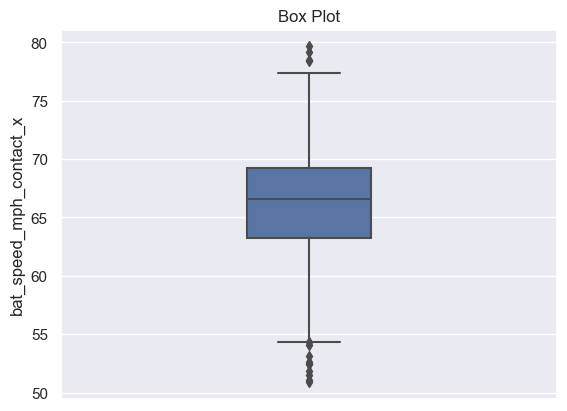

In [442]:
# Box plot
sb.boxplot(df, y = "bat_speed_mph_contact_x", width=.25)
plt.title("Box Plot")
plt.show()

/Users/zach_landry/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


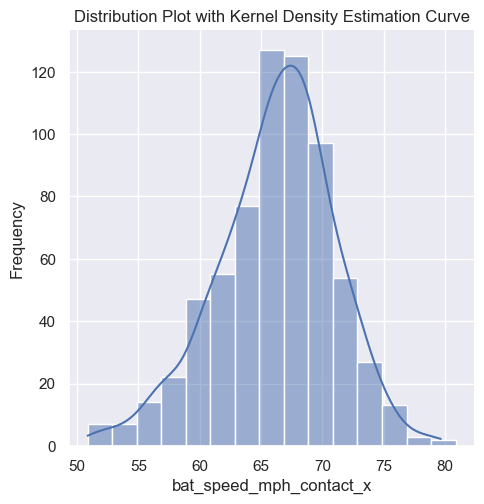

In [443]:
sb.set_theme()
sb.displot(df, x="bat_speed_mph_contact_x", binwidth = 2, kde=True)
plt.title("Distribution Plot with Kernel Density Estimation Curve")
plt.ylabel("Frequency")
plt.show()

The histogram and kernal density estimation curve show a unimodal, bell-shaped distribution of `bat_speed_mph_contact_x` and appears to have an approximately normal distribution. 

## Feature Variables

### Column Selection and Missingness
For simplicity and interpretability purposes, not all 129 variables can be included in the model. Therefore, a subset of columns in the dataset will be used as feature/predictor variables. First, certain columns associated with bat speed such as exit velocity, sweet-spot velocity, and hand speed are dropped from the original dataset. Additionally, `bat_torso_angle_ds_y` is dropped since it is the same as `bat_torso_angle_connection_x`, and `session` is also excluded since it is a unique identifier, narrowing the number of predictors to 111.

In [444]:
# Drop variables directly related to bat speed and duplicate column `bat_torso_angle_ds_y`
df = df.drop(["session", "bat_torso_angle_ds_y", "exit_velo_mph_x", "blast_bat_speed_mph_x", "sweet_spot_velo_mph_contact_x", "sweet_spot_velo_mph_contact_y", "sweet_spot_velo_mph_contact_z", "bat_speed_mph_max_x", "bat_speed_xy_max_x", "hand_speed_blast_bat_mph_max_x", "hand_speed_mag_max_x", "hand_speed_mag_fm_x", "hand_speed_mag_fp_x", "hand_speed_mag_maxhss_x", "hand_speed_mag_seq_max_x", "hand_speed_mag_stride_max_velo_x", "hand_speed_mag_swing_max_velo_x"], axis=1)

df.shape

(677, 112)

In [445]:
# Check for missingness
df.isnull().sum().sort_values(ascending=False)

bat_speed_mph_contact_x         0
bat_torso_angle_connection_x    0
torso_launchpos_z               0
torso_launchpos_y               0
torso_launchpos_x               0
                               ..
lead_knee_stride_max_x          0
lead_knee_launchpos_x           0
bat_min_x                       0
bat_max_x                       0
athlete_age                     0
Length: 112, dtype: int64

According to the chart above, the dataset has no missing values. 

### Multicollinearity

The variance inflation factor (VIF) quantifies the amount of multicollinearity among the feature variables in the dataset. A VIF greater than 10 indicates that the particular variable is highly correlated with another variable.  

In [446]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Create feature DataFrame (df excluding bat_speed_mph_contact_x)
features = df.drop("bat_speed_mph_contact_x", axis=1)

# Create DataFrame with VIF values for each feature column
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif.sort_values(by="VIF", ascending=False)

/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
28,x_factor_fp_z,inf
22,upper_arm_speed_mag_max_x,inf
80,torso_launchpos_y,inf
103,upper_arm_speed_mag_swing_max_velo_x,inf
101,upper_arm_speed_mag_seq_max_x,inf
...,...,...
110,athlete_age,2.505029
1,attack_angle_contact_x,2.236508
98,upper_arm_speed_mag_fm_x,2.179170
3,bat_torso_angle_ds_z,1.679973


In [447]:
sum(np.isinf(vif.VIF)) # number of infinite VIFs

35

According to the above DataFrame, 35 features have infinite VIFs, suggesting perfect multicollinearity. Mathematically, this equates to an R^2 value of either 1 or -1, which intuitively means that one or more variables are exact linear combinations of other variables. To address this multicollinearity issue, the following method will iteratively reduce the set of features until all VIFs fall below 10. A VIF of 10 corresponds to a 0.9 R^2 value, so the final set of features should not have any variables that are highly correlated.

In [448]:
# Write function to calculate VIF for features in a DataFrame
def calculate_vifs(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# Start with the original set of features
reduced_features = features.copy()

# Iterate until all VIFs are less than 10
while True:
    vifs = calculate_vifs(reduced_features)
    max_vif = vifs['VIF'].max()
    if max_vif < 10:
        break
    # Remove the feature with the highest VIF
    feature_to_remove = vifs.sort_values('VIF', ascending=False).iloc[0]['Feature']
    reduced_features = reduced_features.drop(columns=[feature_to_remove])
    #print(f"Removed {feature_to_remove} with VIF {max_vif}")

print("Final set of features:", reduced_features.columns)

/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/zach_landry/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/zach_landry/anacon

Final set of features: Index(['attack_angle_contact_x', 'bat_torso_angle_ds_x',
       'bat_torso_angle_ds_z', 'pelvis_angle_fm_z', 'pelvis_angle_fp_y',
       'pelvis_angle_hs_y', 'torso_angle_fp_z', 'x_factor_fm_x',
       'x_factor_fp_x', 'x_factor_fp_y', 'bat_min_x', 'lead_wrist_fm_x',
       'lead_wrist_swing_max_x', 'pelvis_angular_velocity_fm_x',
       'pelvis_swing_max_x', 'pelvis_swing_max_z', 'rear_hip_stride_max_y',
       'rear_shoulder_stride_max_x', 'rear_shoulder_stride_max_z',
       'torso_angular_velocity_fm_x', 'torso_fm_y', 'torso_pelvis_loadedpos_x',
       'torso_swing_max_z', 'upper_arm_speed_mag_fm_x', 'x_factor_hs_z'],
      dtype='object')


Many of the highly correlated variables are measured at points of the swing that happen close together, such as heel strike and first move. Or angular velocities of body parts that are close together, such as pelvis and torso.

In [449]:
len(reduced_features.columns)

25

# Model Building

## Train-Test Split

In [450]:
from sklearn.model_selection import train_test_split

# Features and target variable
features = reduced_features.columns
target = ['bat_speed_mph_contact_x']

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=23)

# Size of training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((541, 25), (136, 25), (541, 1), (136, 1))

Now, the data has successfully been split into training and test sets which have 541 and 136 samples, respectively. 

## Multiple Linear Regression

The first model will use multiple linear regression (MLR) to estimate `bat_speed_mph_contact_x` using the newly created training and test datasets. 

In [451]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Linear Regression model
mlr_model = LinearRegression()

# Train model using training data
mlr_model.fit(X_train, y_train)

# Predict target variable for the test set
y_pred = mlr_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

mse, rmse, r2

(20.205922930925766, 4.495099879972164, 0.31240087785363413)

The MLR model is evaluated using the following performance metrics:

- Mean Squared Error (MSE): 20.21
- Root Mean Squared Error (RMSE): 4.50
- R-squared (R^2): 0.31

The R^2 value of 0.31 suggests that the model explains approximately 31% of the variance in the bat speeds within the test dataset. The RMSE value shows that the average difference between the model's predicted values and the actual values in the test dataset is about 4.5 mph. 

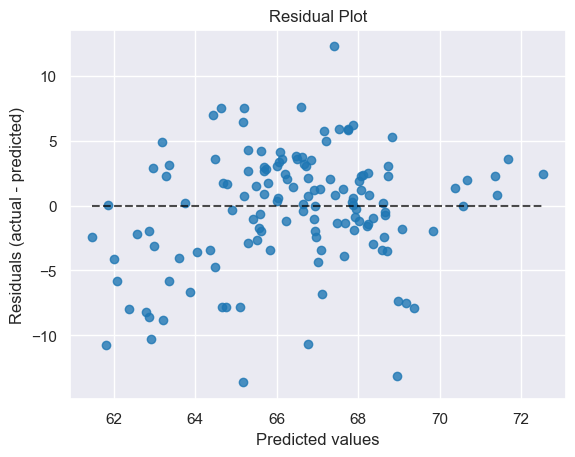

In [452]:
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred)
plt.title("Residual Plot")
plt.show()

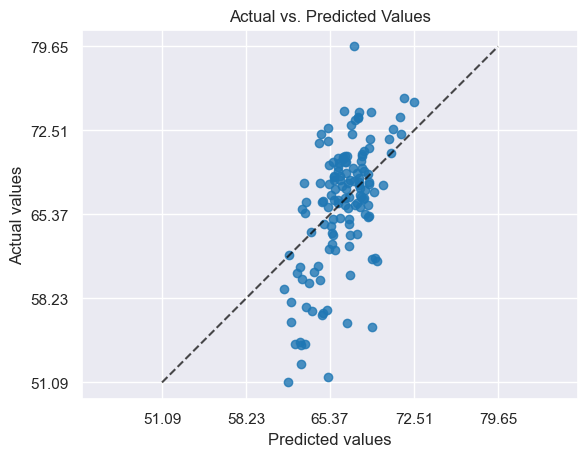

In [453]:
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, kind="actual_vs_predicted")
plt.title("Actual vs. Predicted Values")
plt.show()

In general, the residual plot shows no clear patterns as the points appear to be relatively symmetrically distributed. However, there appear to be multiple predictions that are off by more than 10 mph, which is less than ideal and probably due to the outliers in the dataset. 

### Outliers

The presence of outliers, which was previously noted by the box plot of bat speeds, tend to affect the calculation of regression coefficients, skewing the slope and intercept of the line. Therefore, these outliers will be identified using the interquartile range (IQR) approach. IQR is the difference between the third quartile (Q3) and the first quartile (Q1). Values that are above or below the following upper and lower bounds, respectively, are labeled outliers and removed from the dataset:

- Upper Bound: Q3 + 1.5 * IQR
- Lower Bound: Q1 - 1.5 * IQR 

In [454]:
print("Old shape:", df.shape)

Old shape: (677, 112)


In [455]:
# Create a copy of the original DataFrame
new_df = df.copy()

# Calculate Q1, Q3, and IQR
Q1 = new_df["bat_speed_mph_contact_x"].quantile(0.25) 
Q3 = new_df["bat_speed_mph_contact_x"].quantile(0.75) 
IQR = Q3 - Q1 

# Establish upper and lower bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create arrays of Boolean values indicating the outlier rows
outliers = new_df["bat_speed_mph_contact_x"].apply(lambda x: x > upper or x < lower)

# Removing the outliers
new_df = new_df[~outliers]

# Print the new shape of the DataFrame
print("New shape:", new_df.shape)

New shape: (663, 112)


Fourteen observations are considered outliers according to the IQR definition and have been removed from the dataset. 

In [456]:
# Features and target variable
features = reduced_features.columns
target = ['bat_speed_mph_contact_x']

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(new_df[features], new_df[target], test_size=0.2, random_state=23)

# Size of training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((530, 25), (133, 25), (530, 1), (133, 1))

In [457]:
# Initialize Linear Regression model
mlr_model = LinearRegression()

# Train model using training data
mlr_model.fit(X_train, y_train)

# Predict target variable for the test set
y_pred = mlr_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

mse, rmse, r2

(18.296140294735288, 4.277398776679033, 0.096456013274276)

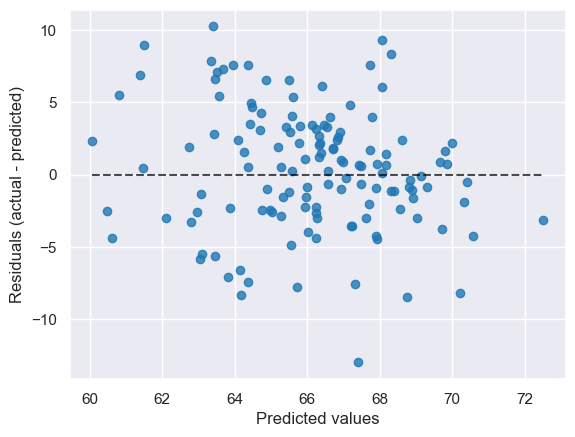

In [458]:
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

## Elastic Net

Elastic net regularization is particularly useful for regression models where multicollinearity exists among the features and/or when you want to perform feature selection. The regularization term in elastic net is a linear combination of L1 and L2 penalties, which essentially control the complexity and capacity of the model. The L1 (Lasso) penalty helps in reducing the number of features by shrinking coefficients to zero (effectively performing feature selection) while the L2 (Ridge) penalty shrinks the coefficients towards zero but does not set them to zero, which helps in dealing with multicollinearity.

`ElasticNetCV()` is a function from scikit-learn designed specifically for regression models incorporating this type of regularization. The "CV" stands for cross validation, indicating that this implementation automatically performs cross validation to determine the best parameters for the model, specifically focusing on the regularization strength (`alpha`) and the mix between L1 and L2 penalties (`l1_ratio`).

Most of the default parameters are used for this model, but a list of values for `l1_ratio` is used instead of the 0.5 default value. The `l1_ratio` in elastic net regression controls the balance between L1 (Lasso) and L2 (Ridge) penalties. A higher `l1_ratio` pushes more coefficients to zero, which is useful for feature reduction and enhancing model simplicity. Conversely, a lower `l1_ratio` integrates more L2 penalty and handles features with high collinearity. By passing a list of these values, the function performs cross-validation to test each value and ultimately selects the one yielding the best prediction score. 

The function also automates the process of selecting the best `alpha` (i.e. regularization strength) through cross validation. It tests 100 different values of this parameters by default with each `l1_ratio` and evaluates the model's performance for each combination using 5-fold cross validation. 

Lastly, feature scaling ensures that each feature contributes equally to the regularization process, allowing the model to converge more quickly and accurately. Unscaled or unnormalized features can disproportionately influence the penalty applied to different coefficients, leading to biased estimates and an inefficient learning process.

In [459]:
# Features list containing all columns
features = df.drop("bat_speed_mph_contact_x", axis=1).columns

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=23)

# Shape of training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((541, 111), (136, 111), (541, 1), (136, 1))

The full dataset (including outliers) is used for the train-test split with 541 observations in the training set and 136 observations in the test set. The model incorporates all 111 features as it is designed to automatically address the multicollinearity issue. 

In [460]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # transformed according to the scale fitted for X_train

# Initialize Elastic Net Regression model
EN_reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000, tol=0.001)

# Train the model
EN_reg.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on test set
y_pred = EN_reg.predict(X_test_scaled)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

mse, rmse, r2

(6.40526138664962, 2.5308617873462826, 0.7820316289617508)

In [461]:
print("Alpha:", EN_reg.alpha_)
print("L1 ratio:", EN_reg.l1_ratio_)

Alpha: 0.0076708394577706986
L1 ratio: 0.5


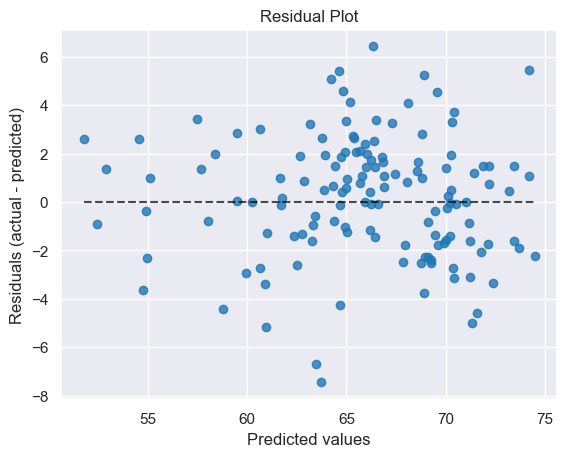

In [462]:
# Plot residuals
PredictionErrorDisplay.from_predictions(y_true=y_test.values.ravel(), y_pred=y_pred)
plt.title("Residual Plot")
plt.show()

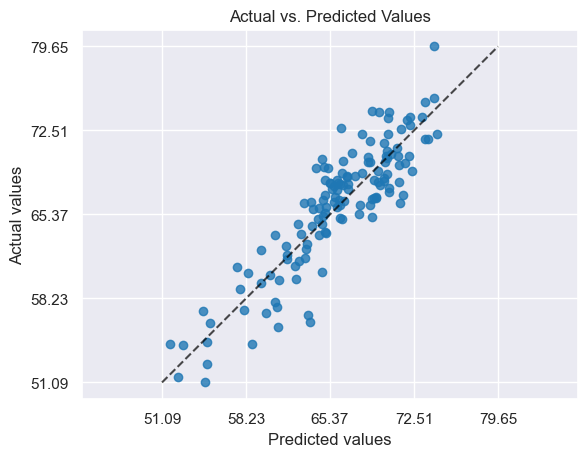

In [463]:
# Plot Actual versus Predicted values
PredictionErrorDisplay.from_predictions(y_true=y_test.values.ravel(), y_pred=y_pred, kind="actual_vs_predicted")
plt.title("Actual vs. Predicted Values")
plt.show()

### Feature Importance

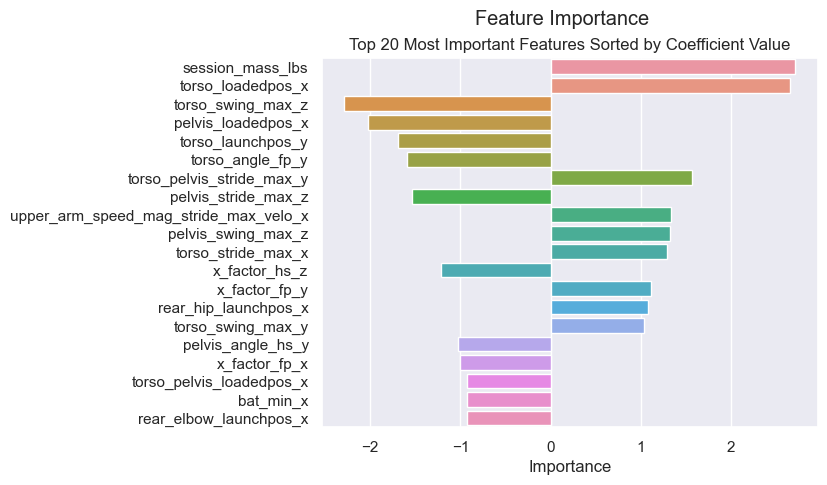

In [464]:
# Extract coefficients
coef = EN_reg.coef_

# Create DataFrame to view feature names and corresponding coefficients
feature_coef = pd.DataFrame({
    "Feature": features,
    "Coefficient": coef
})

# Sort by absolute value of coefficients in descending order
feature_coef.sort_values(by="Coefficient", key=abs, ascending=False, inplace=True)

# View top 10 most important features
sb.barplot(x="Coefficient", y="Feature", data=feature_coef.head(20))
plt.xlabel("Importance")
plt.ylabel("")
plt.title("Top 20 Most Important Features Sorted by Coefficient Value")
plt.suptitle("Feature Importance")
plt.show()